<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/COMPAS_Clustering_K_Means_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy import stats
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

# Load data

In [185]:
data_shaperr = pd.read_csv('/content/Shap_error_data.csv')

# Split data into tp/fn and tn/fp

In [186]:
'''Drop rows where both TP and FN are '''
def drop_zero_TP_FN(data):
    return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

'''Drop rows where both TN and FP are 0'''

def drop_zero_TN_FP(data):
    return data.loc[(data['TN'] == 1) | (data['FP'] == 1)]

TPFN_data = drop_zero_TP_FN(data_shaperr)
TNFP_data = drop_zero_TN_FP(data_shaperr)

In [187]:
TNFP_data.head()

,age,priors_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,...,Shap_race_Native American,Shap_race_Other,predicted_class,true_class,errors,TP,TN,FN,FP,Error_Type
0,-0.746845,-0.094066,-0.494734,0.494734,0.981167,-0.067641,-0.716158,-0.313915,-0.052726,-0.239983,...,0.035609,-0.144069,0.0,0.0,0.0,0.0,1.0,0.0,0.0,TN
3,-0.746845,0.727079,-0.494734,0.494734,-1.019194,-0.067641,1.396340,-0.313915,-0.052726,-0.239983,...,0.035609,0.192882,1.0,0.0,1.0,0.0,0.0,0.0,1.0,FP
4,0.007586,-0.709925,2.021287,-2.021287,-1.019194,-0.067641,-0.716158,3.185577,-0.052726,-0.239983,...,0.035609,-0.221036,1.0,0.0,1.0,0.0,0.0,0.0,1.0,FP
7,1.432621,-0.709925,2.021287,-2.021287,-1.019194,-0.067641,-0.716158,-0.313915,-0.052726,4.166970,...,0.035609,1.217333,1.0,0.0,1.0,0.0,0.0,0.0,1.0,FP
8,-1.249799,-0.709925,-0.494734,0.494734,0.981167,-0.067641,-0.716158,-0.313915,-0.052726,-0.239983,...,0.035609,0.270869,0.0,0.0,0.0,0.0,1.0,0.0,0.0,TN


In [188]:
TPFN_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1579 entries, 1 to 5048
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         1579 non-null   float64
 1   priors_count                1579 non-null   float64
 2   sex_Female                  1579 non-null   float64
 3   sex_Male                    1579 non-null   float64
 4   race_African-American       1579 non-null   float64
 5   race_Asian                  1579 non-null   float64
 6   race_Caucasian              1579 non-null   float64
 7   race_Hispanic               1579 non-null   float64
 8   race_Native American        1579 non-null   float64
 9   race_Other                  1579 non-null   float64
 10  Shap_age                    1579 non-null   float64
 11  Shap_priors_count           1579 non-null   float64
 12  Shap_sex_Female             1579 non-null   float64
 13  Shap_sex_Male               1579 non-n

# Utils

In [189]:
'''Pca on scaled features'''
def pca_plot(data, title, alpha = 0.5):
    # Extract features for PCA and drop certain columns
    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'clusters', 'new_clusters',
                              #'Shap_age', 'Shap_priors_count' , 'Shap_sex_Female', 'Shap_sex_Male', 'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian', 'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other'
                              ], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'clusters', 'new_clusters',
                           #'Shap_age', 'Shap_priors_count' , 'Shap_sex_Female', 'Shap_sex_Male', 'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian', 'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other'
                           ]]

    # Apply PCA with 2 components to scaled features and create a df for the resulting principal components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(pca_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index, columns=['Principal Component 1', 'Principal Component 2'])

    # Create temporary dataset that contains both principal components and other features
    temp_dataset = pca_df.join(other_features, how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_dataset, x='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="clusters", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

'''Initialization of dataset to scale the features and errors, which can be in/excluded for clustering.
Returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which is required for HBAC '''

def initialize_dataset(data, with_errors=True, just_features=True, scale_features=True, with_classes=True):

    new_data = data.copy(deep=True)
    features = new_data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type'], axis=1)

    if with_errors:
        error_columns = ['TP', 'TN', 'FN', 'FP', 'errors']
        new_data[error_columns] *= 0.8 #scaling factor

    if just_features:
        drop_columns = ['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type']
        new_data = new_data.drop(drop_columns, axis = 1)

    if scale_features:
        to_scale = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type'], axis=1).columns
        new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])

    if with_classes:
      for col in ['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type',
                  #'Shap_age', 'Shap_priors_count' , 'Shap_sex_Female', 'Shap_sex_Male', 'Shap_race_African-American',
                  #'Shap_race_Asian', 'Shap_race_Caucasian', 'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other'
                  ]:
            new_data[col] = data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1

    return new_data

'''Calculate accuracy on error'''

def accuracy_error (results, error = 'FN'): #change to FP/FN
  if len(results) == 0:
    print ("you are calculating the accuracy on an empty cluster")
  correct = results.loc[results[error] == 0]
  acc = len(correct)/ len(results)
  return acc

'''Calculate bias based on accuracy_error. The accuracy of a selected cluster - accruacy of the remaining clusters
 Colster col: name of the DF column where the cluster assignments are'''

def bias_w_error (data, cluster_id, cluster_col):
  cluster_x = data.loc[data[cluster_col] == cluster_id]

  if len(cluster_x) ==0:
    print("this is an empty cluster", cluster_id)
  remaining_clusters = data.loc[data[cluster_col] != cluster_id]

  if len(remaining_clusters) ==0:
    print ("This cluster is the entire dataset. Cluster:", cluster_id)
  return accuracy_error(cluster_x) - accuracy_error(remaining_clusters)

'''Returns a value for max negative and positive bias. returns a value'''

def get_max_bias(data, bias_type = 'negative'): #function = bias_w_error
  max_bias = float('inf')
  if bias_type == 'negative':
    max_bias = -float('inf') #initializes max_bias with either positive of negative infinity (special floating point value) based on bias_type param


  for cluster_number in data['new_clusters'].unique():
    if cluster_number == -1:#outliers in dbscan
      continue

    current_bias = bias_w_error(data, cluster_number, 'new_clusters') #for each cluster the bias_w_error function is calculated

    if (bias_type == 'negative' and current_bias < max_bias) or (bias_type == 'positive' and current_bias > max_bias):
      max_bias = current_bias
  print(f'Maximum {bias_type} bias is:', max_bias)
  return max_bias


'''Returns a cluster for max neg bias (for newly added clusters)'''

def get_cluster_max_bias(data, function = bias_w_error):
  max_pos_bias = 100 #max_abs bias selma code
  max_bias_cluster = -2
  for cluster_number in data['clusters'].unique():
    if cluster_number == -1:
      continue
    current_bias = (function(data, cluster_number, 'clusters')) #pos function to find the highest bias
    print(f"{cluster_number} has bias {current_bias}")
    if current_bias < max_pos_bias:
      max_pos_bias = current_bias
      max_bias_cluster = cluster_number
  print ('cluster with the highest discriminating bias:', max_bias_cluster)
  return max_bias_cluster

'''Select a new cluster to split on based on the smallest absolute difference from the overall error rate of 0.5
Function requires a df.columns named 'clusters' and an error column (fp or fn)'''

def select_new_cluster(data, error_column=None, overall_error_rate=0.5):
    smallest_diff = 1
    selected_cluster = None

    if error_column is None:
        error_column = 'FP'  # Default to 'FP' if error_column is not specified

    for cluster_number in data['clusters'].unique():
        if cluster_number == -1:
            continue
        cluster_data = data[data['clusters'] == cluster_number]
        cluster_error_rate = cluster_data[error_column].mean()  # Use specified error column
        abs_diff = abs(overall_error_rate - cluster_error_rate)

        if abs_diff < smallest_diff:
            smallest_diff = abs_diff
            selected_cluster = cluster_number

    return selected_cluster

'''Calculate variance based on error'''

def calculate_variance(data):
  variance_list_local = []
  for j in data['clusters'].unique():
    average_acc = accuracy_error(data)
    bias_clus = bias_w_error(data, j, 'clusters')
    variance_list_local.append(bias_clus)
  variance = np.var(variance_list_local)
  return variance

'''Calculate bias_acc_global'''

def calculate_bias_global_average(data, cluster_id, cluster_col, ave_acc):
  cluster_x = data.loc[data[cluster_col] == cluster_id]
  return accuracy_error(cluster_x) - ave_acc

'''Get min splittable cluster size - returns size of smallest new cluster'''
def min_split_cluster_size(data):
  min_cluster_size = len(data)
  for i in data['new_clusters'].unique():
    if i == -1:
      continue
    size = len(data.loc[data['new_clusters']==i])
    if size < min_cluster_size:
      min_cluster_size = size
  return min_cluster_size


'''Select a random cluster from provided list of clusters that is not -1'''
def get_random_cluster(clusters):
  result = -1
  while (result == -1):
    result = random.randint(0, len(clusters.unique()))
  print('This is the random cluster we picked:', result)
  return result

'''Plot cluster '''
def plot_clusters(data):
  scatterplot = sns.scatterplot(data=data, x='1st', y='2nd', hue="clusters", size = 'errors', sizes=(100, 20), palette = "tab10")
  plt.show()

'''Tsne plot'''
def tsne_plot(data, title, perplexity = 30, learning_rate = 200, n_iter = 1000, alpha = 0.5):
    tsne_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'clusters', 'new_clusters',
                              #'Shap_age', 'Shap_priors_count' , 'Shap_sex_Female', 'Shap_sex_Male', 'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian', 'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other'
                              ], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'clusters', 'new_clusters',
                           #'Shap_age', 'Shap_priors_count' , 'Shap_sex_Female', 'Shap_sex_Male', 'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian', 'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other'
                           ]]


    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    tsne_result = tsne.fit_transform(tsne_features)
    tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

    temp_dataset = tsne_df.join(other_features, how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, hue="clusters", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    plt.show()

In [190]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [191]:
clus_model_kwargs = { "n_clusters": 2,
    "init": "k-means++", #method used to initialize the initial cluster centroids.
    "n_init": 10, #nr of times K-means  will be run with different centroid seeds
    "max_iter": 300,}

In [192]:
print(TPFN_data.columns)
print

Index(['age', 'priors_count', 'sex_Female', 'sex_Male',
       'race_African-American', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native American', 'race_Other', 'Shap_age',
       'Shap_priors_count', 'Shap_sex_Female', 'Shap_sex_Male',
       'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian',
       'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other',
       'predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP',
       'Error_Type'],
      dtype='object')


<function print>

In [193]:
FN_data = initialize_dataset(TPFN_data)
FN_data.head()

,age,priors_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,...,predicted_class,true_class,errors,TP,TN,FN,FP,Error_Type,clusters,new_clusters
1,0.440419,0.114094,1.975785,-1.975785,-1.008267,-0.06673,-0.740297,3.410572,-0.050395,-0.242942,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,FN,0,-1
6,0.186677,4.208502,-0.506128,0.506128,0.991801,-0.06673,-0.740297,-0.293206,-0.050395,-0.242942,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,FN,0,-1
11,1.455387,-0.704788,1.975785,-1.975785,-1.008267,-0.06673,1.350810,-0.293206,-0.050395,-0.242942,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,TP,0,-1
14,-0.828290,0.318814,-0.506128,0.506128,0.991801,-0.06673,-0.740297,-0.293206,-0.050395,-0.242942,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,FN,0,-1
18,-0.236226,-0.090627,-0.506128,0.506128,0.991801,-0.06673,-0.740297,-0.293206,-0.050395,-0.242942,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,TP,0,-1


# Clustering with K-means

# FN

In [194]:
def FN_bias_with_error_rate_kmeans(data = FN_data, max_iter = 30, plot_clusters = True):
  clus_model_kwargs = { "n_clusters": 2,
                       "init": "k-means++", #method used to initialize the initial cluster centroids.
                        "n_init": 10, #nr of times K-means will be run with different centroid seeds
                        "max_iter": max_iter,
                        }

  #full_data = initialize_dataset(data)

  x = 0 #initial cluster nr
  initial_bias = 0

  variance_list = []
  acc = accuracy_error(data, error = 'FN') #Calculating accuracy based on FN error

  min_splittable_cluster_size = round(0.05 * len(data)) #
  min_acceptable_cluster_size = round(0.03 * len(data))
  print("accuracy is:", acc)

  #Loop for clustering iterations
  for i in range(1, max_iter):
    if len(data['clusters'].unique()) != 1:
      variance_list.append(calculate_variance(data)) #variance calculation is performed if the nr of unique clusters is not equal to 1
      data['new_clusters'] = -1
    candidate_cluster = data.loc[data['clusters'] == x]

    if len(candidate_cluster) < min_splittable_cluster_size:
      x = get_random_cluster(data['clusters'])
      continue

    kmeans = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'clusters', 'new_clusters',
                                                                     #'Shap_age', 'Shap_priors_count' , 'Shap_sex_Female', 'Shap_sex_Male', 'Shap_race_African-American', 'Shap_race_Asian',
                                                                     #'Shap_race_Caucasian', 'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other'
                                                                     ],axis=1))

    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors', 'TP',
                                        'TN', 'FN', 'FP', 'Error_Type',
                                        #'Shap_age', 'Shap_priors_count', 'Shap_sex_Female',
                                        #'Shap_sex_Male', 'Shap_race_African-American', 'Shap_race_Asian',
                                        #'Shap_race_Caucasian', 'Shap_race_Hispanic', 'Shap_race_Native American',
                                        #'Shap_race_Other'
                                        ], axis=1)), index=candidate_cluster.index)
    data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])


    max_discr_bias = get_max_bias(data, 'negative')

    min_cluster_size = min_split_cluster_size(data)
    print('Smallest cluster size:', min_cluster_size)

    if (max_discr_bias <= initial_bias) & (min_cluster_size > min_acceptable_cluster_size):
      print ("adding a new cluster")
      n_cluster = max(data['clusters'])
      data['clusters'][data['new_clusters'] == 1] = n_cluster + 1

      if plot_clusters:
        pca_plot(data, 'K-means for False Negatives', 0.6)

      x = select_new_cluster(data, error_column = 'FN')
      initial_bias = max_discr_bias

    else:
      x = get_random_cluster(data['clusters'])

  print('MAX_ITER')
  print(variance_list)
  return data



accuracy is: 0.5250158328055732
Maximum negative bias is: -inf
Smallest cluster size: 322
adding a new cluster
Explained Variance Ratio: PC1 = 0.14, PC2 = 0.11


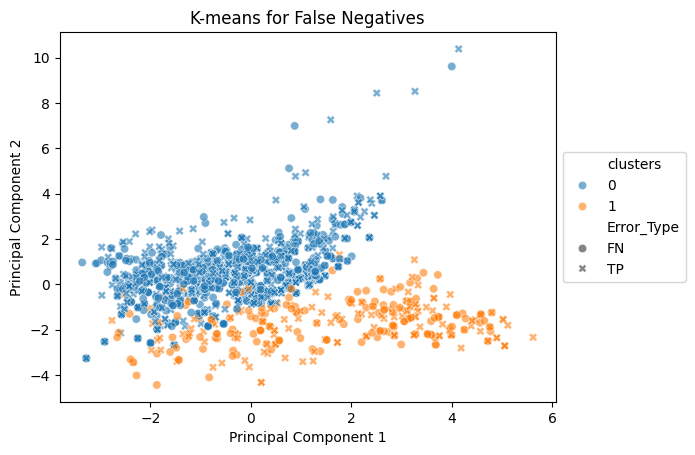

Maximum negative bias is: -inf
Smallest cluster size: 139
adding a new cluster
Explained Variance Ratio: PC1 = 0.14, PC2 = 0.11


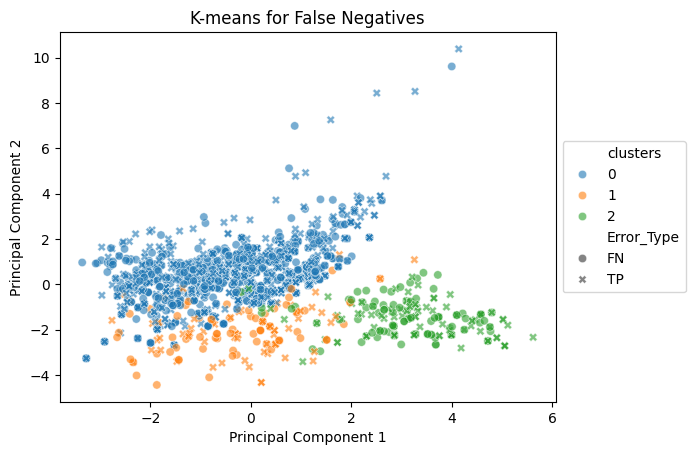

Maximum negative bias is: -inf
Smallest cluster size: 55
adding a new cluster
Explained Variance Ratio: PC1 = 0.14, PC2 = 0.11


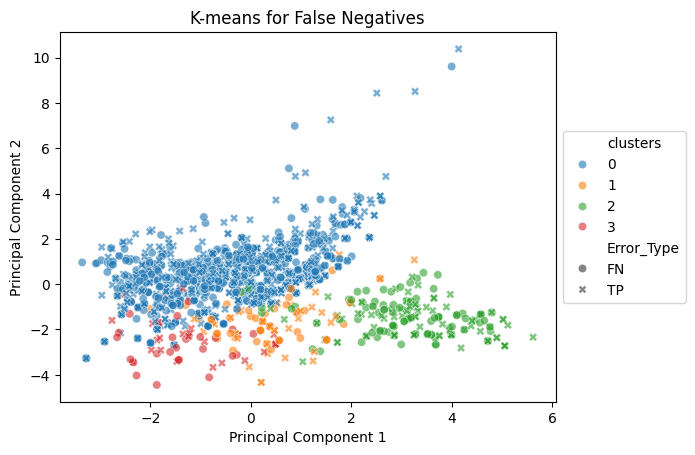

This is the random cluster we picked: 0
Maximum negative bias is: -inf
Smallest cluster size: 6
This is the random cluster we picked: 2
Maximum negative bias is: -inf
Smallest cluster size: 80
adding a new cluster
Explained Variance Ratio: PC1 = 0.14, PC2 = 0.11


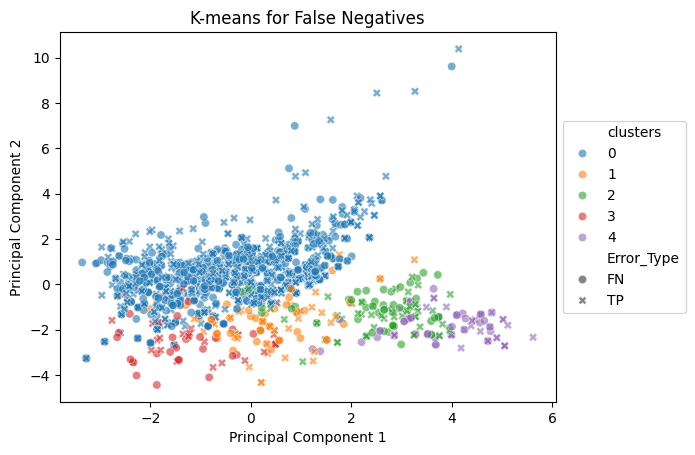

This is the random cluster we picked: 1
Maximum negative bias is: -inf
Smallest cluster size: 13
This is the random cluster we picked: 2
Maximum negative bias is: -inf
Smallest cluster size: 51
adding a new cluster
Explained Variance Ratio: PC1 = 0.14, PC2 = 0.11


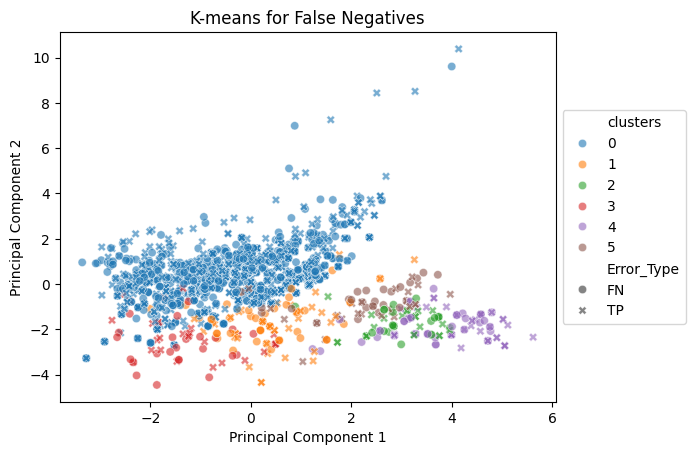

This is the random cluster we picked: 2
This is the random cluster we picked: 1
Maximum negative bias is: -inf
Smallest cluster size: 13
This is the random cluster we picked: 6
This is the random cluster we picked: 3
This is the random cluster we picked: 0
Maximum negative bias is: -inf
Smallest cluster size: 565
adding a new cluster
Explained Variance Ratio: PC1 = 0.14, PC2 = 0.11


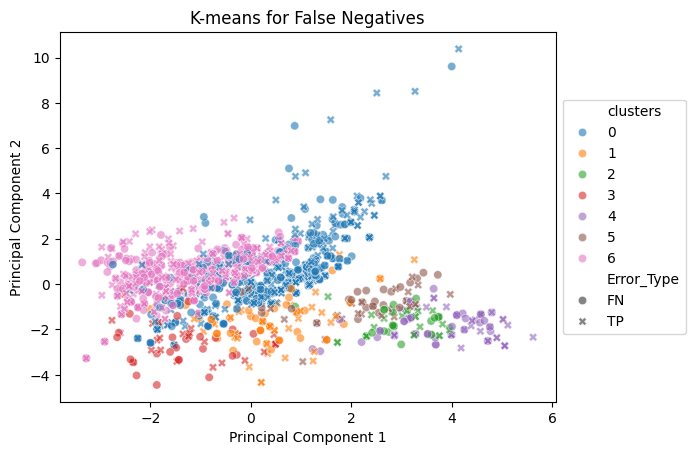

This is the random cluster we picked: 6
Maximum negative bias is: -inf
Smallest cluster size: 31
This is the random cluster we picked: 0
Maximum negative bias is: -inf
Smallest cluster size: 7
This is the random cluster we picked: 1
Maximum negative bias is: -inf
Smallest cluster size: 13
This is the random cluster we picked: 5
This is the random cluster we picked: 6
Maximum negative bias is: -inf
Smallest cluster size: 304
adding a new cluster
Explained Variance Ratio: PC1 = 0.14, PC2 = 0.11


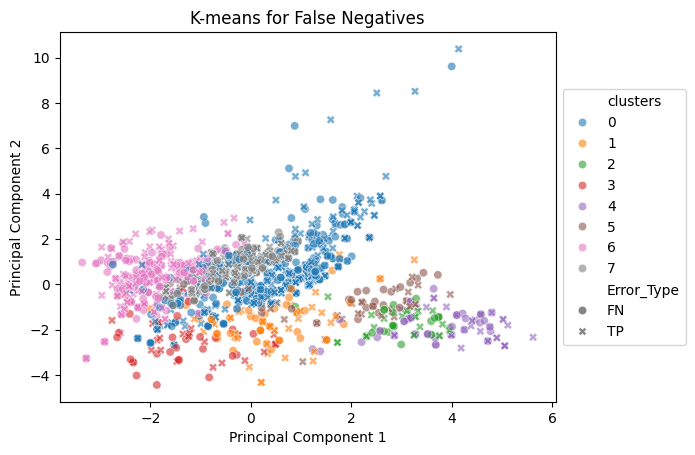

This is the random cluster we picked: 0
Maximum negative bias is: -inf
Smallest cluster size: 4
This is the random cluster we picked: 7
Maximum negative bias is: -inf
Smallest cluster size: 193
adding a new cluster
Explained Variance Ratio: PC1 = 0.14, PC2 = 0.11


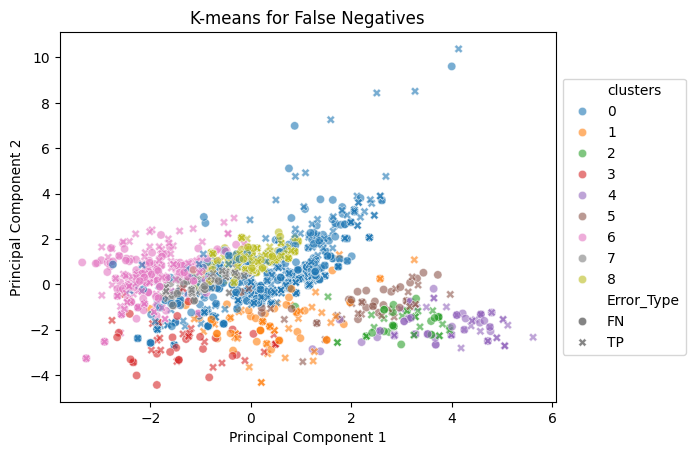

Maximum negative bias is: -inf
Smallest cluster size: 85
adding a new cluster
Explained Variance Ratio: PC1 = 0.14, PC2 = 0.11


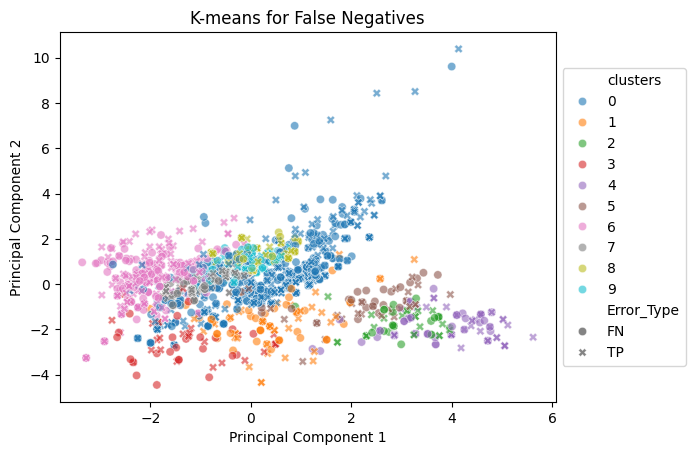

Maximum negative bias is: -inf
Smallest cluster size: 34
This is the random cluster we picked: 0
Maximum negative bias is: -inf
Smallest cluster size: 7
This is the random cluster we picked: 9
Maximum negative bias is: -inf
Smallest cluster size: 24
This is the random cluster we picked: 3
This is the random cluster we picked: 9
MAX_ITER
[0.000388902869995607, 0.0011254671940651058, 0.001185284084926314, 0.001185284084926314, 0.001185284084926314, 0.001171359129556056, 0.001171359129556056, 0.001171359129556056, 0.0009998229457334415, 0.0009998229457334415, 0.0009998229457334415, 0.0009998229457334415, 0.0009998229457334415, 0.0009998229457334415, 0.0009127386690218681, 0.0009127386690218681, 0.0009127386690218681, 0.0009127386690218681, 0.0009127386690218681, 0.0009127386690218681, 0.0008071544643196156, 0.0008071544643196156, 0.0008071544643196156, 0.0009953829684971175, 0.0009779017711209423, 0.0009779017711209423, 0.0009779017711209423, 0.0009779017711209423]


,age,priors_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,...,predicted_class,true_class,errors,TP,TN,FN,FP,Error_Type,clusters,new_clusters
1,0.440419,0.114094,1.975785,-1.975785,-1.008267,-0.06673,-0.740297,3.410572,-0.050395,-0.242942,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,FN,1,-1
6,0.186677,4.208502,-0.506128,0.506128,0.991801,-0.06673,-0.740297,-0.293206,-0.050395,-0.242942,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,FN,6,-1
11,1.455387,-0.704788,1.975785,-1.975785,-1.008267,-0.06673,1.350810,-0.293206,-0.050395,-0.242942,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,TP,3,-1
14,-0.828290,0.318814,-0.506128,0.506128,0.991801,-0.06673,-0.740297,-0.293206,-0.050395,-0.242942,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,FN,6,-1
18,-0.236226,-0.090627,-0.506128,0.506128,0.991801,-0.06673,-0.740297,-0.293206,-0.050395,-0.242942,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,TP,9,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5039,-0.236226,-0.704788,-0.506128,0.506128,0.991801,-0.06673,-0.740297,-0.293206,-0.050395,-0.242942,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,TP,9,-1
5040,-0.489968,-0.704788,-0.506128,0.506128,0.991801,-0.06673,-0.740297,-0.293206,-0.050395,-0.242942,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,TP,7,-1
5041,-1.082032,0.932975,-0.506128,0.506128,0.991801,-0.06673,-0.740297,-0.293206,-0.050395,-0.242942,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,FN,6,-1
5044,-1.082032,-0.500068,-0.506128,0.506128,0.991801,-0.06673,-0.740297,-0.293206,-0.050395,-0.242942,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,FN,7,-1


In [195]:
FN_bias_with_error_rate_kmeans(data = FN_data, max_iter = 30, plot_clusters = True)

# FP

In [196]:
#TNFP_data.head()

In [197]:
FP_data = initialize_dataset(TNFP_data)
#FP_data.head()

In [198]:
def FP_bias_with_error_rate_kmeans(data = FP_data, max_iter = 30, plot_clusters = True):
  clus_model_kwargs = { "n_clusters": 2,
                       "init": "k-means++", #method used to initialize the initial cluster centroids.
                        "n_init": 10, #nr of times K-means will be run with different centroid seeds
                        "max_iter": max_iter,
                        }

  #full_data = initialize_dataset(data)

  x = 0 #initial cluster nr
  initial_bias = 0

  variance_list = []
  acc = accuracy_error(data, error = 'FP') #Calculating accuracy based on FN error

  min_splittable_cluster_size = round(0.05 * len(data)) #
  min_acceptable_cluster_size = round(0.03 * len(data))
  print("accuracy is:", acc)

  #Loop for clustering iterations
  for i in range(1, max_iter):
    if len(data['clusters'].unique()) != 1:
      variance_list.append(calculate_variance(data)) #variance calculation is performed if the nr of unique clusters is not equal to 1
      data['new_clusters'] = -1
    candidate_cluster = data.loc[data['clusters'] == x]

    if len(candidate_cluster) < min_splittable_cluster_size:
      x = get_random_cluster(data['clusters'])
      continue

    kmeans = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'clusters', 'new_clusters',
                                                                     #'Shap_age', 'Shap_priors_count' , 'Shap_sex_Female', 'Shap_sex_Male', 'Shap_race_African-American', 'Shap_race_Asian',
                                                                     #'Shap_race_Caucasian', 'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other'
                                                                     ],axis=1))

    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors', 'TP',
                                        'TN', 'FN', 'FP', 'Error_Type',
                                        #'Shap_age', 'Shap_priors_count', 'Shap_sex_Female',
                                        #'Shap_sex_Male', 'Shap_race_African-American', 'Shap_race_Asian',
                                        #'Shap_race_Caucasian', 'Shap_race_Hispanic', 'Shap_race_Native American',
                                        #'Shap_race_Other'
                                        ], axis=1)), index=candidate_cluster.index)
    data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])


    max_discr_bias = get_max_bias(data, 'negative')

    min_cluster_size = min_split_cluster_size(data)
    print('Smallest cluster size:', min_cluster_size)

    if (max_discr_bias <= initial_bias) & (min_cluster_size > min_acceptable_cluster_size):
      print ("adding a new cluster")
      n_cluster = max(data['clusters'])
      data['clusters'][data['new_clusters'] == 1] = n_cluster + 1

      if plot_clusters:
        pca_plot(data, 'K-means for False Positives', 0.6)

      x = select_new_cluster(data, error_column = 'FP')
      initial_bias = max_discr_bias

    else:
      x = get_random_cluster(data['clusters'])

  print('MAX_ITER')
  print(variance_list)
  return data


accuracy is: 0.668542199488491
Maximum negative bias is: -inf
Smallest cluster size: 327
adding a new cluster
Explained Variance Ratio: PC1 = 0.15, PC2 = 0.12


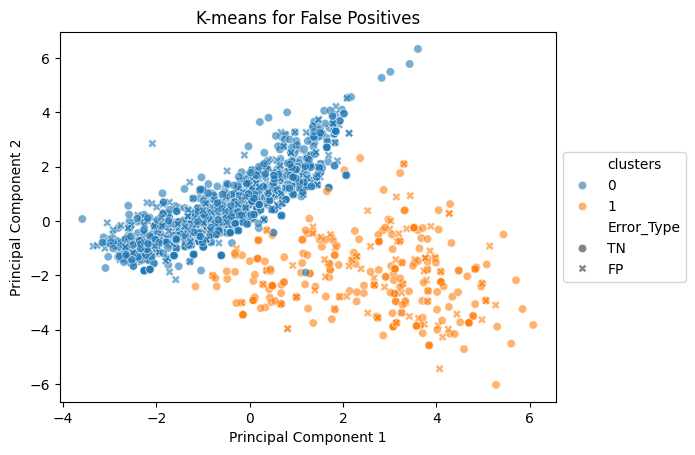

Maximum negative bias is: -inf
Smallest cluster size: 769
adding a new cluster
Explained Variance Ratio: PC1 = 0.15, PC2 = 0.12


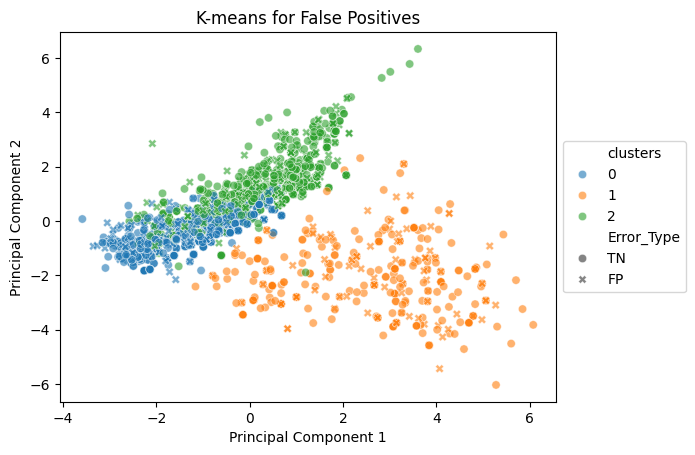

Maximum negative bias is: -inf
Smallest cluster size: 38
This is the random cluster we picked: 3
This is the random cluster we picked: 1
Maximum negative bias is: -inf
Smallest cluster size: 3
This is the random cluster we picked: 0
Maximum negative bias is: -inf
Smallest cluster size: 38
This is the random cluster we picked: 1
Maximum negative bias is: -inf
Smallest cluster size: 3
This is the random cluster we picked: 2
Maximum negative bias is: -inf
Smallest cluster size: 7
This is the random cluster we picked: 0
Maximum negative bias is: -inf
Smallest cluster size: 38
This is the random cluster we picked: 0
Maximum negative bias is: -inf
Smallest cluster size: 38
This is the random cluster we picked: 0
Maximum negative bias is: -inf
Smallest cluster size: 334
adding a new cluster
Explained Variance Ratio: PC1 = 0.15, PC2 = 0.12


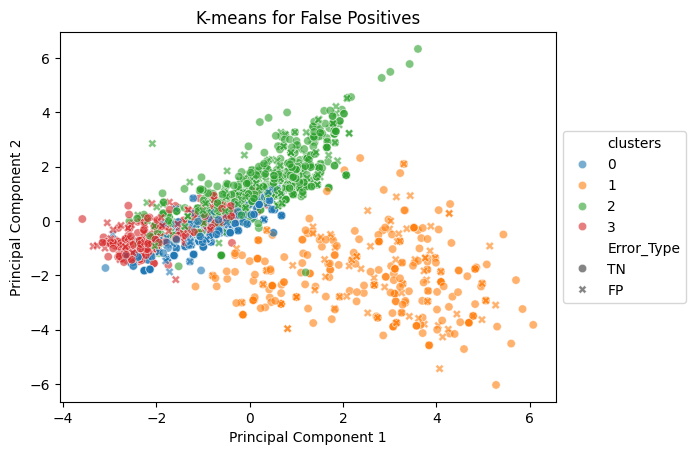

Maximum negative bias is: -inf
Smallest cluster size: 36
This is the random cluster we picked: 4
This is the random cluster we picked: 1
Maximum negative bias is: -inf
Smallest cluster size: 3
This is the random cluster we picked: 0
Maximum negative bias is: -inf
Smallest cluster size: 36
This is the random cluster we picked: 3
Maximum negative bias is: -inf
Smallest cluster size: 147
adding a new cluster
Explained Variance Ratio: PC1 = 0.15, PC2 = 0.12


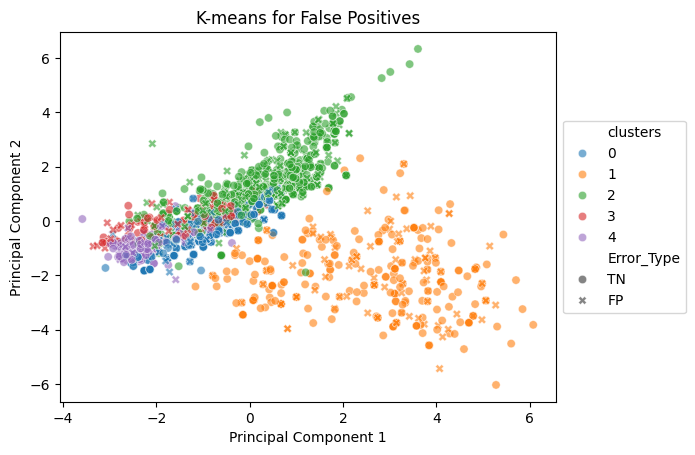

Maximum negative bias is: -inf
Smallest cluster size: 36
This is the random cluster we picked: 1
Maximum negative bias is: -inf
Smallest cluster size: 3
This is the random cluster we picked: 1
Maximum negative bias is: -inf
Smallest cluster size: 3
This is the random cluster we picked: 4
Maximum negative bias is: -inf
Smallest cluster size: 9
This is the random cluster we picked: 4
Maximum negative bias is: -inf
Smallest cluster size: 9
This is the random cluster we picked: 1
Maximum negative bias is: -inf
Smallest cluster size: 3
This is the random cluster we picked: 0
Maximum negative bias is: -inf
Smallest cluster size: 36
This is the random cluster we picked: 3
Maximum negative bias is: -inf
Smallest cluster size: 53
This is the random cluster we picked: 4
Maximum negative bias is: -inf
Smallest cluster size: 9
This is the random cluster we picked: 4
Maximum negative bias is: -inf
Smallest cluster size: 9
This is the random cluster we picked: 1
Maximum negative bias is: -inf
Smalle

In [199]:
FP_bias_with_error_rate_kmeans(data = FP_data, max_iter = 30, plot_clusters = True)
plt.show()

# Identifying the most discriminated cluster

In [200]:
def most_disc_cluster(data = FP_data):

  disc_clus = get_cluster_max_bias(data)
  most_biased_cluster = data[data['clusters']== disc_clus]
  len(most_biased_cluster)

  accuracy_data = accuracy_error(data, error = 'FN') #change this to FP/FN accordingly
  most_biased_kmeans = bias_w_error(data, disc_clus, 'clusters')
  data[data['clusters']== disc_clus]

  print('General accuracy of classifier on this dataset:', accuracy_error)
  print('Number of clusters: ', data['clusters'].unique())
  print(f"cluster {disc_clus} has the highest discrimination bias")
  print(most_biased_kmeans)

In [201]:
most_disc_cluster(data = FP_data) #cluster 2 for FP - have to change accuracy_error error coilumn to fp in the utils

0 has bias 0.0
2 has bias 0.0
1 has bias 0.0
4 has bias 0.0
3 has bias 0.0
cluster with the highest discriminating bias: 0
General accuracy of classifier on this dataset: <function accuracy_error at 0x7fad16af08b0>
Number of clusters:  [0 2 1 4 3]
cluster 0 has the highest discrimination bias
0.0


In [202]:
most_disc_cluster(data = FN_data) #cluster 1 for FN - have to change accuracy_error error coilumn to fn in the utils

1 has bias -0.06414237935977063
6 has bias -0.014685242518059805
3 has bias -0.03533762825101411
9 has bias -0.04509016457988818
0 has bias 0.025813827651812726
7 has bias 0.0328923966207203
2 has bias 0.00454265475823834
8 has bias -0.026852481305234543
4 has bias 0.02631754503002004
5 has bias -0.005982066394640051
cluster with the highest discriminating bias: 1
General accuracy of classifier on this dataset: <function accuracy_error at 0x7fad16af08b0>
Number of clusters:  [1 6 3 9 0 7 2 8 4 5]
cluster 1 has the highest discrimination bias
-0.06414237935977063
